In [1]:
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

from itertools import chain

from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,Input,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [2]:
import tensorflow as tf

In [3]:
base_train_dir = 'train/'  # Путь до папки с картинками из обуч. выборки
base_test_dir = 'test/'    # Из тестовой

# Работа с картинками

Для корректной работы все картинки были переведены в серый цвет. Сжатие/Расширение проводилось до разрешения 150x150 с помощью библиотеки opencv. Для лучшей работы была проведена аугменация картинок: с вероятностью в 50% картинка отзеркаливалась по горизонтали, 5% по вертикали, также с вероятностью в 50% проводилось афинное преобразование( вращение в пределах -20 до 20 градусов). Аугментация проводилась с помощью библиотеки imgaug, т.к. аналогичные преобразования было необходимо проводить для координат ключевых точек, а используемый мной фреймворк для глубинного обучения(tensorflow) представлял преобразование только для картинок.

В процессе преобразований были картинки с выпадающими из разрешения координат ключевых точек, было решено выкинуть их из выборки (количество таких картинок << результирующей выборки). 

# Архитектура

Архитектура такова: в структуре сети 4 свёрточных слоя для поиска необходимых сегментов расположения. В самом первом для сохранения информации разрешения картинки параметр padding = 'same' (данное решение было одним из ключевых для улучшения качества). Размер фильтра 1-го свёрточного слоя рекомендуется сделать как можно больше (не количество, а именно размер - увеличение кол-ва приводило к серьёзному увеличению времени обучения), размеры остальных можно поменьше, главное, чтобы они убывали. После каждого свёрточного слоя для предотвращения обучения использовался слой Dropout (влияло). После каждых двух свёрточных слоёв использовался слой MaxPool для сокращения параметров (не успел попробовать, но по моему предположению, именно размер последнего MaxPooling слоя влияет на пропорцию между координатами ключевых точек). Функция активации для каждого свёрточного слоя - relu.

После первого MaxPooling-слоя использовался BatchNormalization-слой (не сильно повлиял на значение ошибки).

Финальный слой состоял из 28 нейронов.

После предсказания модели при нанесении ключевых точек на картинку можно заметить, что предсказанные значения не совпадают так, как нам(мне) бы хотелось, но при домножении координат точек на коэффициент 1.25, немного решает эту проблему.


In [22]:
from collections import OrderedDict


class FaceDetectionSystem(object):
    
    def __init__(self,image_size=(100,100)):
        self.image_size = image_size
        self.images = None
        self.key_dots = None
        
    def scale_images(self, image_path, new_image_path,key_dots_path=None):
        if key_dots_path is not None:
            df = pd.read_csv(key_dots_path)
            coord_list = df.columns.tolist()[1::]
            coordinates = df[coord_list]
        if not os.path.exists(new_image_path):
            os.mkdir(new_image_path)
        im_list = os.listdir(image_path)
        imgs = OrderedDict()  # у os свой порядок файлов, поэтому я использовал OrderedDict
        for image_name in im_list:
            img_gbr = cv2.imread(image_path+image_name)
            img_rgb = cv2.cvtColor(img_gbr, cv2.COLOR_BGR2RGB)  
            if key_dots_path is not None:
                scaling_x, scaling_y = self.image_size[0] / img_rgb.shape[0], \
                self.image_size[1] / img_rgb.shape[1]  #масштабирующие коэффициенты для ключ. точек
                new_X_coordinates  = (coordinates.loc[df['filename'] == image_name,  
                                                  coord_list[::2]].values[0] * scaling_x).astype(int).tolist()
                new_Y_coordinates  = (coordinates.loc[df['filename'] == image_name, 
                                                  coord_list[1::2]].values[0] * scaling_y).astype(int).tolist()
                key_dots = list(zip(new_X_coordinates,new_Y_coordinates))
            else:
                key_dots = None
            resized = cv2.resize(img_rgb,self.image_size,interpolation = cv2.INTER_AREA)
            imgs[image_name] = [(np.mean(resized,axis=2))[...,np.newaxis],
                                key_dots] if key_dots_path is not None else \
                                [(np.mean(resized,axis=2))[...,np.newaxis]]
            cv2.imwrite(new_image_path+image_name,resized)
        images = np.array(list(map(lambda x: x[0], imgs.values()))) / 255
        
        key_dots = list(map(lambda x: x[1], imgs.values())) if key_dots_path is not None else None
        
        return images,key_dots
    
    def image_dots_augmentation(self,images,keypoints,percent_augmentation=0.5):
    
        def to_2d(keypoints_array):
            """
            Разворачивает трёхмерный список в двумерный.
            img_aug требует координаты точек как трёхмерный список размерности im_count*dot_count*dot_coord,
            но потом необходимо развернуть.
            """
            return np.array([list(chain(*keypoints_array[i])) for i in range(len(keypoints_array))])
        
        transformation = iaa.Sequential([
            iaa.Fliplr(0.5),  # гориз. отзеркаливание
            iaa.Flipud(0.02), # вертик. отзеркаливание
            iaa.Sometimes(percent_augmentation,iaa.Affine(  # афинное преобразование, прим. для половины картинок
            rotate=(-20, 20),
            order=[0, 1],
            mode=ia.ALL))    
        ],random_order=True)
        
        img_aug, keypoints_aug = transformation(
            images = images,
            keypoints = keypoints)
        
        keypoints_aug = to_2d(keypoints_aug).astype(int)
        keypoints = to_2d(keypoints)
        """
        Удаляем картинки, где в результате трансформации, координаты ключ. точек вышли за разрешение
        """
        img_aug = np.delete(img_aug,np.where(keypoints_aug > self.image_size[0])[0],0)  
        keypoints_aug = np.delete(keypoints_aug,np.where(keypoints_aug > self.image_size[0])[0],0)  
        
        im_with_aug = np.concatenate((images,img_aug),axis=0)  # Соединяем аугментированную часть с обычной
        key_with_aug = np.concatenate((keypoints,keypoints_aug),axis=0)
        
        shuffled_indices = np.arange(im_with_aug.shape[0])  # Перемешиваем
        random.shuffle(shuffled_indices)
        return im_with_aug[shuffled_indices], key_with_aug[shuffled_indices].tolist()
    
    def fit_model(self,x,y):
        inp = Input(shape=x[0].shape)
        h = Conv2D(16, kernel_size=(30,30),activation='relu',padding='same')(inp)
        h = MaxPooling2D(pool_size = (2,2))(h)
        h = Dropout(0.15)(h)
        
        h = Conv2D(20, kernel_size=(25,25),activation='relu')(h)
        h = MaxPooling2D(pool_size = (2,2))(h)
        h = Dropout(0.15)(h)
        
        h = BatchNormalization()(h)
        
        h = Conv2D(64, kernel_size=(10,10),activation='relu', padding='same')(h)
        h = MaxPooling2D(pool_size = (2,2))(h)
        h = Dropout(0.15)(h)
        
        h = Conv2D(80, kernel_size=(5,5),activation='relu')(h)
        h = MaxPooling2D(pool_size = (2,2))(h)
        h = Dropout(0.15)(h)
        
        
        h = Flatten()(h)
        h = Dense(50,activation='relu')(h)
        h = Dropout(0.3)(h)
        h = Dense(28,activation='relu')(h)
        model = Model(inputs=inp,outputs=h)
        checkpoint_path = 'checkpoints/'
        checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_best_only=True)
        stop = EarlyStopping(patience=2)
        model.compile(optimizer='adam',loss='mae',metrics=['mse'])
        print(model.summary())
        model.fit(x,y,batch_size=32,validation_split=0.2,epochs = 20,callbacks = [checkpoint,stop])
        return model       

In [23]:
system = FaceDetectionSystem(image_size=(150,150))
imgs,keypoints_w = system.scale_images(base_train_dir,'preprocessing_images/','train.csv')
img_aug, keypoints_aug = system.image_dots_augmentation(imgs,keypoints_w)

In [24]:
img_aug.shape,len(keypoints_aug),len(keypoints_aug[0])

((9989, 150, 150, 1), 9989, 28)

In [25]:
len(keypoints_w), len(keypoints_w[0]), len(keypoints_w[0][0])

(5000, 14, 2)

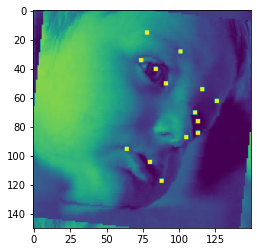

In [26]:
from imgaug.augmentables import Keypoint, KeypointsOnImage
def print_dots(index,array_img,array_keyp):
    image = array_img[index]
    keypoints = array_keyp[index]
    print_kp = []
    for i in range(0,28,2):
        print_kp.append(Keypoint(x=keypoints[i],y=keypoints[i+1]))
    kps = KeypointsOnImage(print_kp,shape=image[:,:,0].shape)
    obj = kps.draw_on_image(image[:,:,0],size=3,color=1)
    plt.imshow(obj)
    plt.show()
  
why = np.random.uniform(1, 4560, size = 100).astype(int)

print_dots(324,img_aug,keypoints_aug)

In [27]:
model = system.fit_model(img_aug, np.array(keypoints_aug))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 16)      14416     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 51, 51, 20)        200020    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 20)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 25, 25, 20)        0   

In [28]:
test_im,_ = system.scale_images('test/','preprocessing_test/')

In [29]:
predictions = model.predict(test_im)

In [ ]:
df = []
pred = (predictions*1.25).tolist()
for i,im_name in enumerate(os.listdir(base_test_dir)):
    row = [im_name] + pred[i]
    df.append(row)
df = pd.DataFrame(df)
df.columns = ['filename','x1','y1','x2','y2','x3','y3','x4','y4','x5','y5','x6','y6','x7',
         'y7','x8','y8','x9','y9','x10','y10','x11','y11','x12','y12','x13','y13','x14','y14']
df.to_csv('test.csv')

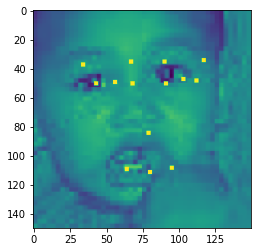

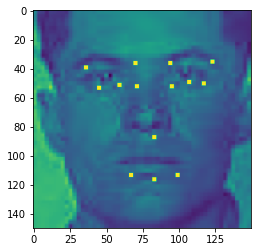

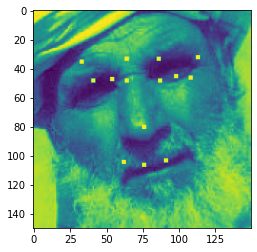

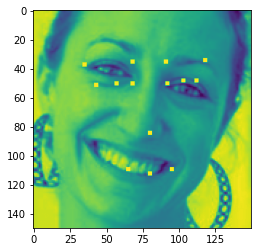

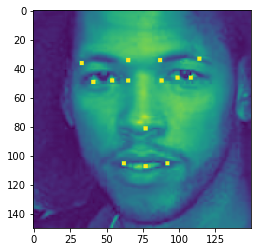

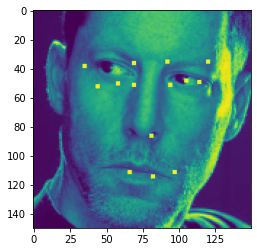

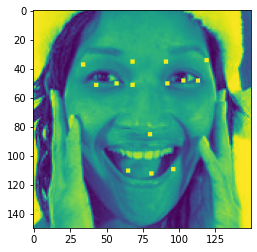

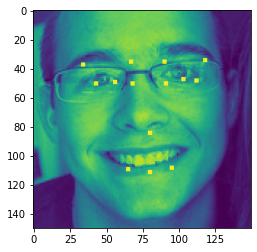

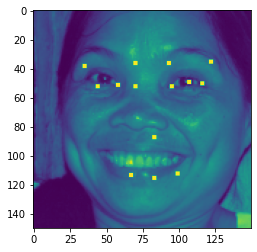

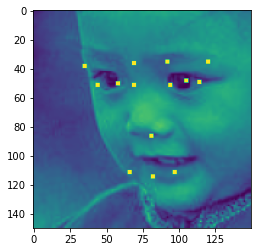

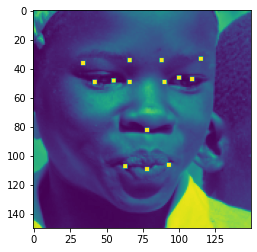

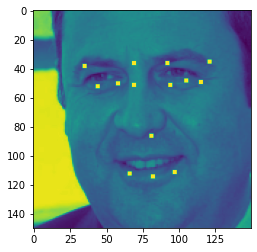

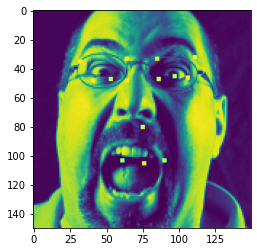

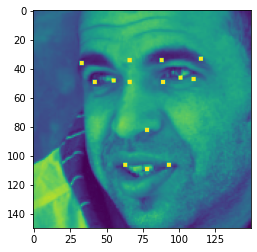

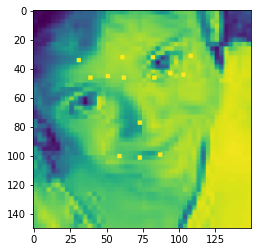

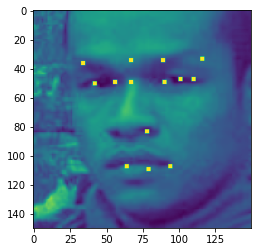

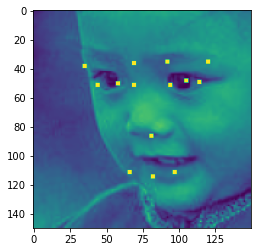

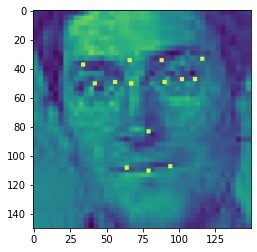

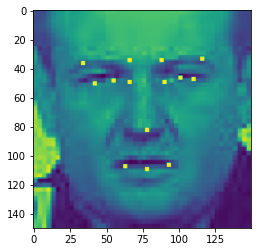

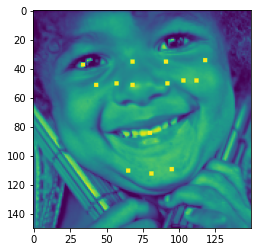

In [31]:
rand = np.random.randint(0,999,size = 20)
for i in range(len(rand)):
    print_dots(rand[i],test_im,1.25*predictions)